In [1]:
import sys
sys.path.append("../../SiMaC/")

In [2]:
import os
import string
import time

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from src.dataset.toy import ToyDataset
from src.ml.model import SiMaC, SiMaCImplicit
from src.ml.layers import ScaledEmbedding
from src.ml.sinkhorn import SinkhornLoss, sinkhorn
from src.ml.train import assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

# Dataset

In [7]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

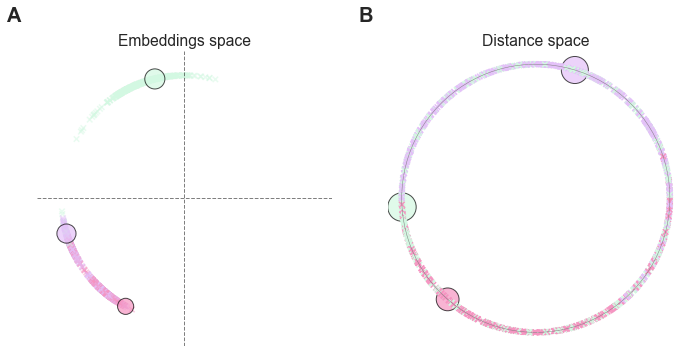

In [8]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    toy.circle_radius,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

# Training

In [38]:
sinkhorn_n_iter = 100
sinkohrn_epsilon = 0.05
n_epochs = 200
learning_rate = 0.005

## SiMaC

In [39]:
def train_simac():
    model = SiMaC(
        capacities=toy.items_capacities,
        n_users=toy.n_users,
        alpha=distance_weight,
        n_features=n_features,
        n_iter=sinkhorn_n_iter,
        epsilon=sinkohrn_epsilon,
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())
    criterion = torch.nn.NLLLoss()

    #########
    # Train #
    #########

    model.train()

    stats = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # Model out
        P = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)

        # Loss
        loss = criterion(torch.log(P), toy.y_true_tensor)
        loss.backward()
        optimizer.step()
        
        epoch_duration = 1000 * (time.time() - start_time)

        # Predictions
        y_pred = assign_with_lap(P, toy.items_capacities)
        f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")

        stats.append([loss.item(), f1, epoch_duration])

    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    
    return stats

In [40]:
_ = train_simac()

Epoch 200: loss=0.120484, F1=0.940


## SiMaC with implicit layers

In [41]:
target = torch.nn.functional.one_hot(
    torch.tensor(toy.assigned_item_for_user),
    num_classes=toy.n_items
)

In [42]:
def train_simac_implicit():
    # define model, loss & optimizer
    model = SiMaCImplicit(
        capacities=toy.items_capacities,
        n_users=toy.n_users,
        alpha=distance_weight,
        n_features=n_features,
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    a = torch.ones(toy.n_users)
    b = torch.FloatTensor(toy.items_capacities).view(-1)

    sinkhorn_loss = SinkhornLoss(
        a=a,
        b=b,
        solver=sinkhorn,
        n_iter=sinkhorn_n_iter,
        epsilon=sinkohrn_epsilon
    )

    optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())

    #########
    # Train #
    #########

    model.train()

    stats = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # Model out
        M = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)

        # Loss
        loss = sinkhorn_loss(M, target)
        loss.backward()
        optimizer.step()
        
        epoch_duration = 1000 * (time.time() - start_time)

        with torch.no_grad():
            P = sinkhorn(M, a, b, sinkohrn_epsilon, sinkhorn_n_iter)

        # Predictions
        y_pred = assign_with_lap(P, toy.items_capacities)
        f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")

        stats.append([loss.item(), f1, epoch_duration])

    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    
    return stats

In [43]:
_ = train_simac_implicit()

Epoch 200: loss=93.601715, F1=0.942


# Experiments

## Run multiple trainings

In [44]:
n_trainings = 10

In [45]:
print("---- Running {0} trainings of SiMaC ----".format(n_trainings))
simac_results = [train_simac() for i in range(n_trainings)]

print("\n---- Running {0} trainings of SiMaC with implicit layers ----".format(n_trainings))
simac_implicit_results = [train_simac_implicit() for i in range(n_trainings)]

---- Running 10 trainings of SiMaC ----
Epoch 200: loss=0.150388, F1=0.906
Epoch 200: loss=0.044101, F1=0.981
Epoch 200: loss=0.029908, F1=0.990
Epoch 200: loss=0.317891, F1=0.853
Epoch 200: loss=0.039627, F1=0.980
Epoch 200: loss=0.099588, F1=0.952
Epoch 200: loss=0.091105, F1=0.945
Epoch 200: loss=0.044439, F1=0.973
Epoch 200: loss=0.063038, F1=0.968
Epoch 200: loss=0.087394, F1=0.948

---- Running 10 trainings of SiMaC with implicit layers ----
Epoch 200: loss=57.094913, F1=0.978
Epoch 200: loss=77.889847, F1=0.951
Epoch 200: loss=69.441353, F1=0.971
Epoch 200: loss=193.050278, F1=0.885
Epoch 200: loss=123.353043, F1=0.917
Epoch 200: loss=70.286789, F1=0.953
Epoch 200: loss=77.380089, F1=0.959
Epoch 200: loss=126.504593, F1=0.924
Epoch 200: loss=76.378387, F1=0.966
Epoch 200: loss=61.386726, F1=0.972


In [46]:
assert np.asarray(simac_results).shape == (n_trainings, n_epochs, 3)
assert np.asarray(simac_implicit_results).shape == (n_trainings, n_epochs, 3)

In [47]:
results_dfs = []

for results in [simac_results, simac_implicit_results]:
    dfs = []
    
    for run_index, run_stats in enumerate(results):
        run_stats_df = pd.DataFrame(run_stats, columns=["loss", "F1", "epoch_duration"])
        run_stats_df["run_index"] = run_index+1
        run_stats_df["epoch"] = np.arange(1, n_epochs+1)

        dfs.append(run_stats_df)
    df = pd.concat(dfs)
    results_dfs.append(df)
        
simac_results_df, simac_implicit_results_df = results_dfs[0], results_dfs[1]

## Plot scores

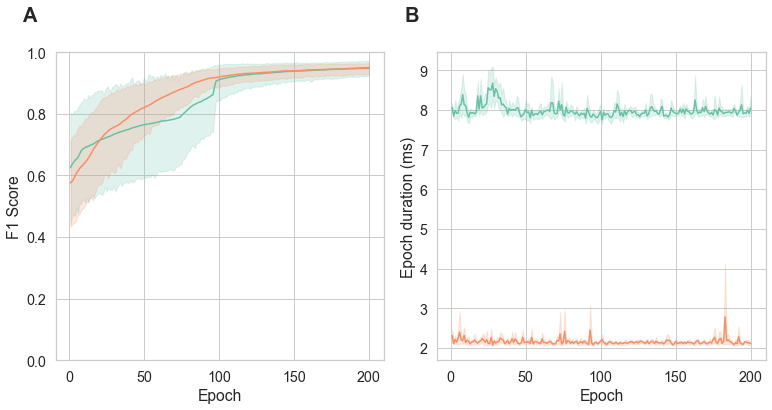

In [51]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 6),
    sharex=True
)

############
# F1 score #
############

ax = axs[0]
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

##################
# Epoch duration #
##################

ax = axs[1]
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch duration (ms)")

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="epoch_duration",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="epoch_duration",
    ax=ax
)

# Annotate subplots with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()